<a href="https://colab.research.google.com/github/ROARMarketingConcepts/Recurrent-Neural-Network-Examples/blob/master/RNN_Training_on_Time_Series_Data_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This RNN will contain 100 recurrent neurons and we will unroll it over 20 time steps since each training instance will be 20 inputs long. Each input will contain only one feature (the value at that time). The targets are also sequences of 20 inputs, each containing a single value.


In [0]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [0]:
import tensorflow as tf

In [0]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution) # t0 is randomly selected and must at least n_steps below t_max.
    Ts = t0 + np.arange(0., n_steps + 1) * resolution                           # Array of evenly spaced values starting at t0
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

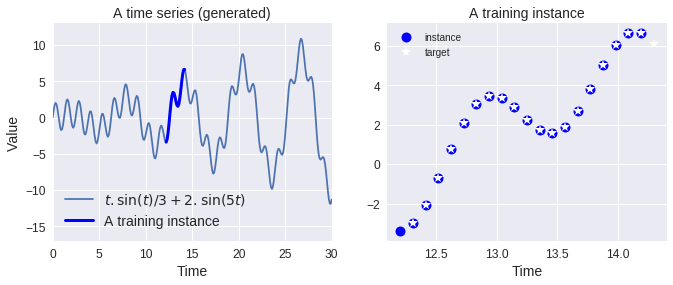

In [4]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance") # t_instance[:-1] means omit last value of t_instance
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


# save_fig("time_series_plot")
plt.show()

In [5]:
X_batch, y_batch = next_batch(1, n_steps)
print(X_batch.shape,y_batch.shape)
print(X_batch[0].shape,y_batch[0].shape)    # slice arrays along '0' dimension

(1, 20, 1) (1, 20, 1)
(20, 1) (20, 1)


In [6]:
np.c_[X_batch[0], y_batch[0]]

array([[ 1.80017686,  1.14618669],
       [ 1.14618669,  0.23732156],
       [ 0.23732156, -0.69631782],
       [-0.69631782, -1.4176229 ],
       [-1.4176229 , -1.74071138],
       [-1.74071138, -1.57663884],
       [-1.57663884, -0.95539278],
       [-0.95539278, -0.01878098],
       [-0.01878098,  1.01404836],
       [ 1.01404836,  1.90001653],
       [ 1.90001653,  2.4313815 ],
       [ 2.4313815 ,  2.48635583],
       [ 2.48635583,  2.05868602],
       [ 2.05868602,  1.25895536],
       [ 1.25895536,  0.28729507],
       [ 0.28729507, -0.61581129],
       [-0.61581129, -1.22858195],
       [-1.22858195, -1.40238764],
       [-1.40238764, -1.09826473],
       [-1.09826473, -0.39654828]])

### Let's create the RNN. It will contain 100 recurrent neurons and we will unroll it over 20 time steps since each training instance will be 20 inputs long. Each input will contain only one feature (the value at that time). The targets are also sequences of 20 inputs, each containing a single value:

In [7]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)                                 # shape of (10000,)

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


### At each time step we now have an output vector of size 100. But what we actually want is a single output value at each time step. The simplest solution is to wrap the cell in an `OutputProjectionWrapper`.

In [0]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)

In [0]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [0]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

In [0]:
init = tf.global_variables_initializer()

In [0]:
saver = tf.train.Saver()  # The Saver class adds ops to save and restore variables to and from checkpoints. 

In [13]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    saver.save(sess, "./my_time_series_model") 

0 	MSE: 11.967254
100 	MSE: 0.52670944
200 	MSE: 0.15034518
300 	MSE: 0.073838525
400 	MSE: 0.065919995
500 	MSE: 0.0599467
600 	MSE: 0.052481826
700 	MSE: 0.0478648
800 	MSE: 0.050174896
900 	MSE: 0.046997838
1000 	MSE: 0.04726432
1100 	MSE: 0.0477391
1200 	MSE: 0.04017511
1300 	MSE: 0.047951132
1400 	MSE: 0.04207592


In [14]:
with tf.Session() as sess:                          
    saver.restore(sess, "./my_time_series_model")   # not shown

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))  # Create new training series interval
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_time_series_model


In [15]:
y_pred

array([[[-3.4068692 ],
        [-2.4720778 ],
        [-1.1405377 ],
        [ 0.78310734],
        [ 2.2498121 ],
        [ 3.106875  ],
        [ 3.408547  ],
        [ 3.3909864 ],
        [ 2.8886044 ],
        [ 2.2290566 ],
        [ 1.6677113 ],
        [ 1.5136182 ],
        [ 1.9115154 ],
        [ 2.737776  ],
        [ 3.8842368 ],
        [ 5.119968  ],
        [ 6.12864   ],
        [ 6.678358  ],
        [ 6.6655393 ],
        [ 6.1140485 ]]], dtype=float32)

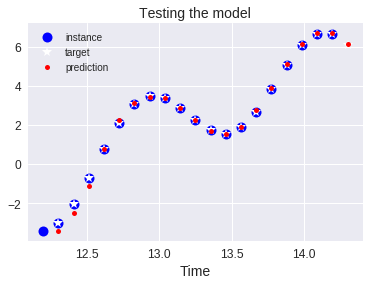

In [16]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

# save_fig("time_series_pred_plot")
plt.show()

### Let's look at the case of not using the `OutputProjectionWrapper`function.

In [0]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [30]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

print('Shape of rnn_outputs:',rnn_outputs.shape,'\nShape of states:',states.shape)

Shape of rnn_outputs: (?, 20, 100) 
Shape of states: (?, 100)


### We stack all the outputs using the reshape() operation, apply the fully connected linear layer (without using any activation function; this is just a projection), and finally unstack all the outputs, again using reshape():


In [32]:
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

print('Shape of stacked_rnn_outputs:',stacked_rnn_outputs.shape,'\nShape of stacked_outputs:',stacked_outputs.shape,
      '\nShape of outputs:',outputs.shape)

Shape of stacked_rnn_outputs: (?, 100) 
Shape of stacked_outputs: (?, 1) 
Shape of outputs: (?, 20, 1)


In [0]:
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [34]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    
    saver.save(sess, "./my_time_series_model")

0 	MSE: 14.435508
100 	MSE: 0.6603948
200 	MSE: 0.21689148
300 	MSE: 0.10313167
400 	MSE: 0.066663004
500 	MSE: 0.062067512
600 	MSE: 0.056068458
700 	MSE: 0.049614154
800 	MSE: 0.050793387
900 	MSE: 0.049161773
1000 	MSE: 0.04889692
1100 	MSE: 0.049303923
1200 	MSE: 0.042905502
1300 	MSE: 0.049072072
1400 	MSE: 0.04233259


In [35]:
y_pred

array([[[-3.411104 ],
        [-2.484228 ],
        [-1.1492898],
        [ 0.8075568],
        [ 2.178394 ],
        [ 3.0891633],
        [ 3.4514782],
        [ 3.3972943],
        [ 2.887993 ],
        [ 2.205911 ],
        [ 1.665656 ],
        [ 1.5806092],
        [ 1.8926574],
        [ 2.7481477],
        [ 3.9238584],
        [ 5.1028886],
        [ 6.0782695],
        [ 6.6405177],
        [ 6.6871557],
        [ 6.0977716]]], dtype=float32)

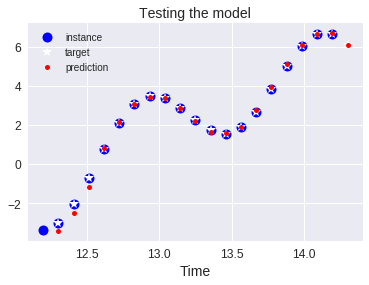

In [36]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

### Now that we have a model that can predict the future, we can use it to generate some creative sequences. All we need is to provide it a seed sequence containing n_steps values (e.g., full of zeros), use the model to predict the next value, append this predicted value to the sequence, feed the last n_steps values to the model to predict the next value, and so on.
 

In [37]:
with tf.Session() as sess:                       
    saver.restore(sess, "./my_time_series_model") 

    sequence = [0.] * n_steps
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./my_time_series_model


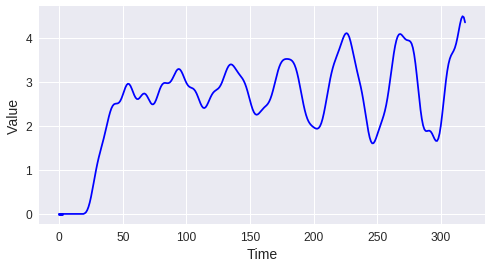

In [38]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

INFO:tensorflow:Restoring parameters from ./my_time_series_model


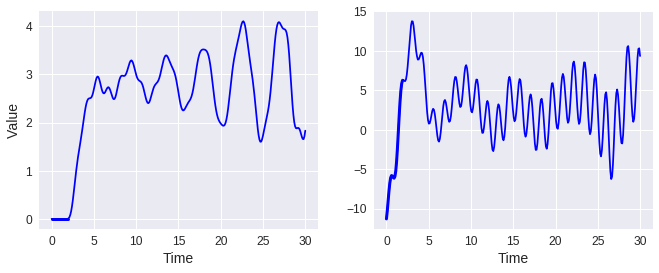

In [40]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")

    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
# save_fig("creative_sequence_plot")
plt.show()